In [1]:
from tqdm import tqdm

from games.kuhn import KuhnPoker
from agents.agent_random import RandomAgent
from agents.counterfactualregret import CounterFactualRegret
from agents.minimax import MiniMax
from base.agent import Agent

In [2]:
kp2 = KuhnPoker(num_agents=2)
kp3 = KuhnPoker(num_agents=3)

In [3]:
def create_agents(agent_types: list[str], game: KuhnPoker, verbose: bool = False) -> dict[str, Agent]:
    agents = {}
    for i, agent in enumerate(game.agents):
        if agent_types[i] == "random":
            agents[agent] = RandomAgent(game=game, agent=agent)
        elif "cfr" in agent_types[i]:
            agents[agent] = CounterFactualRegret(game=game, agent=agent, verbose=verbose)
        elif "minimax" in agent_types[i]:
            depth = int(agent_types[i].split("-")[1]) if "-" in agent_types[i] else 3
            agents[agent] = MiniMax(game=game, agent=agent, depth=depth)
    return agents

In [4]:
def play_game(g: KuhnPoker, agents: dict[str, Agent], verbose: bool = False):
    g.reset()
    while not g.done():
        action = agents[g.agent_selection].action()
        g.step(action)
        if verbose:
            print(f"Agent {g.agent_selection} plays {action}")
            g.render()
    rewards = [g.reward(agent) for agent in g.agents]
    if verbose:
        print(rewards)
    return rewards

In [5]:
agents_2p = create_agents(["cfr", "random"], kp2)
play_game(kp2, agents_2p, verbose=True)

Agent agent_2 plays 1
agent_1 K b
agent_2 Q b
Agent agent_1 plays 0
agent_1 K bp
agent_2 Q bp
[1, -1]


[1, -1]

In [6]:
agents_3p = create_agents(["minimax-3", "minimax-3", "minimax-3"], kp3)
play_game(kp3, agents_3p, verbose=True)

Agent agent_2 plays 0
agent_1 K p
agent_2 Q p
agent_3 L p
Agent agent_3 plays 0
agent_1 K pp
agent_2 Q pp
agent_3 L pp
Agent agent_1 plays 1
agent_1 K ppb
agent_2 Q ppb
agent_3 L ppb
Agent agent_2 plays 0
agent_1 K ppbp
agent_2 Q ppbp
agent_3 L ppbp
Agent agent_3 plays 0
agent_1 K ppbpp
agent_2 Q ppbpp
agent_3 L ppbpp
[-1, -1, 2]


[-1, -1, 2]

In [7]:
def train_agents(
    g: KuhnPoker,
    agents: dict[str, Agent],
    agent_types: list[str] = None,
    n_iters: int = 1000,
    verbose: bool = False
) -> None:
    if agent_types is None:
        agent_types = [""] * len(g.agents)
    for i, agent in enumerate(g.agents):
        n_iters = int(agent_types[i].split("-")[1]) if "cfr" in agent_types[i] and "-" in agent_types[i] else n_iters
        if verbose: print(f"Training agent {agent} for {n_iters} iterations")
        agents[agent].train(n_iters)

In [8]:
train_agents(kp2, agents_2p, n_iters=1000, verbose=True)
play_game(kp2, agents_2p, verbose=True)

Training agent agent_1 for 1000 iterations
Training agent agent_2 for 1000 iterations
Agent agent_2 plays 1
agent_1 J b
agent_2 K b
Agent agent_1 plays 0
agent_1 J bp
agent_2 K bp
[1, -1]


[1, -1]

In [9]:
def play_multiple_games(
    g: KuhnPoker,
    agents: dict[str, Agent],
    agent_types: list[str] = None,
    niter: int = 2000,
    verbose: bool = False
) -> dict[str, float]:
    cum_rewards = dict(map(lambda agent: (agent, 0.), g.agents))
    rec = range(niter)
    if verbose:
        rec = tqdm(range(niter), desc="Playing games")
    for _ in rec:
        play_game(g, agents, verbose=verbose)
        for agent in g.agents:
            cum_rewards[agent] += g.rewards[agent]
    
    if verbose:
        print(" ")
        print(f"Comparing agents: {agent_types if agent_types is not None else agents} with {niter} iterations")
        print("Results:")
        print('--------------------------------')
        print(' - Average rewards:', dict(map(lambda agent: (agent, cum_rewards[agent]/niter), g.agents)))
        print(' - Cumulative rewards:', cum_rewards)
        print('--------------------------------')
        print(" ")
    return cum_rewards


In [ ]:
play_multiple_games(kp2, agents_2p, niter=2000, verbose=True)

In [11]:
def compare_agents(agents_to_compare: list[str], n_iters: int = 2000, step: int = None, verbose: bool = False) -> dict[str, float]:
    assert len(agents_to_compare) == 2 or len(agents_to_compare) == 3, "Only 2 or 3 agents can be compared"
    if step is None:
        step = n_iters

    game = kp2 if len(agents_to_compare) == 2 else kp3
    agents = create_agents(agents_to_compare, game)
    agent_name_map = {agent: agents_to_compare[int(agent.split("_")[1])-1] for agent in game.agents}

    cum_rewards = {agent: 0. for agent in game.agents}
    avg_rewards_by_time = {agent: [] for agent in agents_to_compare}
    for i in range(0, n_iters, step):
        train_agents(game, agents, agent_types=agents_to_compare, verbose=verbose)
        step_cum_rewards = play_multiple_games(game, agents, niter=step, agent_types=agents_to_compare, verbose=verbose)
        cum_rewards = {agent: cum_reward + step_cum_rewards[agent] for agent, cum_reward in cum_rewards.items()}
        for agent in game.agents:
            avg_rewards_by_time[agent_name_map[agent]].append(step_cum_rewards[agent] / step)

    avg_rewards = {agent_name_map[agent] : cum_reward / n_iters for agent, cum_reward in cum_rewards.items()}
    return {
        'cum_rewards': { 
            agent_name_map[agent] :
                cum_reward for agent, cum_reward in cum_rewards.items()
        },
        'avg_rewards': avg_rewards,
        'avg_rewards_by_time': avg_rewards_by_time
    }

In [ ]:
_ = compare_agents(["minimax-1", "cfr-100"], n_iters=2000, verbose=True)

In [ ]:
_ = compare_agents(["minimax-2", "random", "cfr-100"], verbose=True)

In [14]:
def barplot(results: dict[str, float], title: str, ylabel: str) -> None:
    colors = ['brown', 'orange', 'olive']
    plt.bar(results.keys(), results.values(), color=colors[:len(results)])
    plt.title(title)
    plt.xlabel("Agent")
    plt.ylabel(ylabel)
    plt.show()

def rewards_by_time(avg_rewards_by_agent: dict[str, list[float]], step: int) -> None:
    """
    Plot the average rewards over time for all training agents.
    
    Args:
        avg_rewards_by_agent: Dictionary mapping agent names to their average rewards over time
        step: Number of training iterations per step
    """
    colors = ['orange', 'purple', 'brown', 'olive']
    
    plt.figure(figsize=(10, 6))
    
    # Plot each agent's rewards
    for i, (agent_name, avg_rewards) in enumerate(avg_rewards_by_agent.items()):
        steps = [j * step for j in range(1, len(avg_rewards)+1)]
        color = colors[i % len(colors)]
        plt.plot(steps, avg_rewards, color=color, linewidth=2, marker='o', markersize=4, label=agent_name)
    
    plt.title('Average Reward Over Time - All Agents')
    plt.xlabel('Training Iterations')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
    plt.show()

In [15]:
from matplotlib import pyplot as plt

def plot_results(results: dict[str, float], title: str, graphs: list[str] = None) -> None:
    if graphs is None:
        graphs = ['cum_rewards', 'avg_rewards', 'avg_rewards_by_time']

    for graph in graphs:
        if graph == 'avg_rewards_by_time':
            rewards_by_time(results[graph], 100)
        else:
            barplot(results[graph], title, graph)
    

In [16]:
def run_experiment(agents_to_compare: list[str], n_iters: int = 2000, step: int = 1000, verbose: bool = False, graphs: list[str] = None):
    results = compare_agents(agents_to_compare, n_iters=n_iters, step=step, verbose=verbose)
    plot_results(results, f"KuhnPoker {len(agents_to_compare)}p - agents: {agents_to_compare}", graphs=graphs)

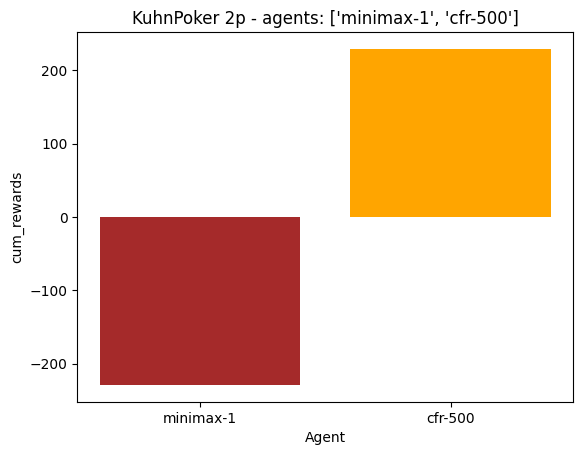

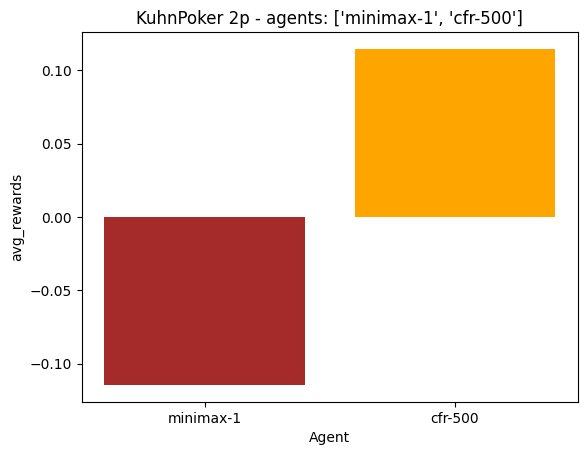

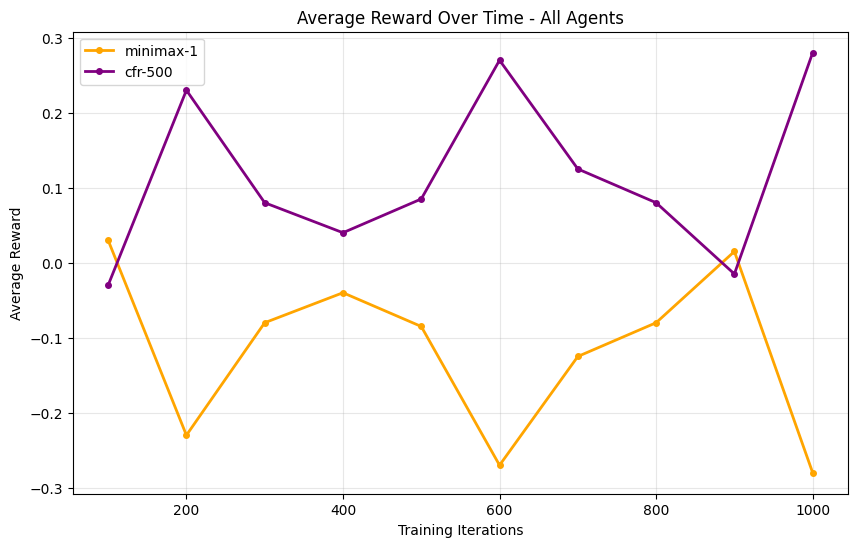

In [25]:
run_experiment(["minimax-1", "cfr-500"], n_iters=2000, step=200)

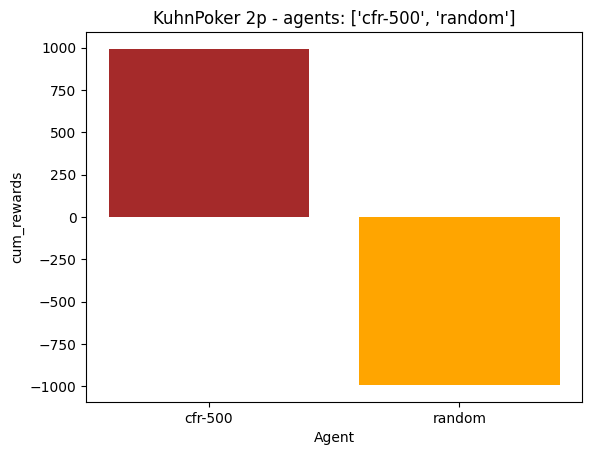

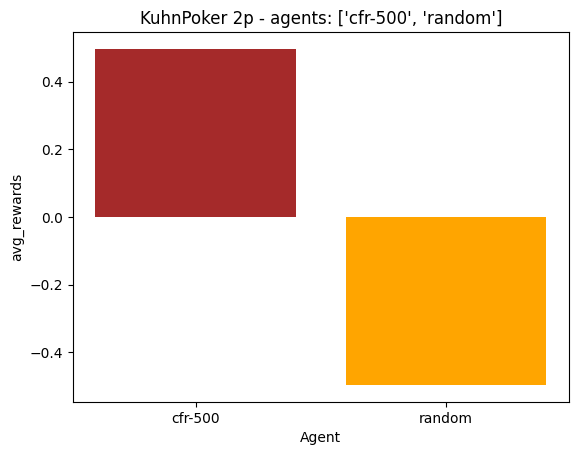

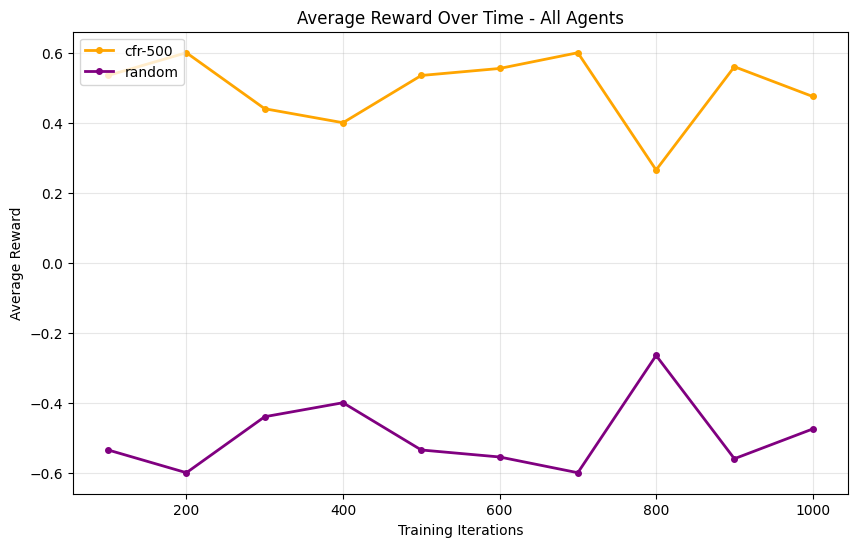

In [26]:
run_experiment(["cfr-500", "random"], n_iters=2000, step=200)

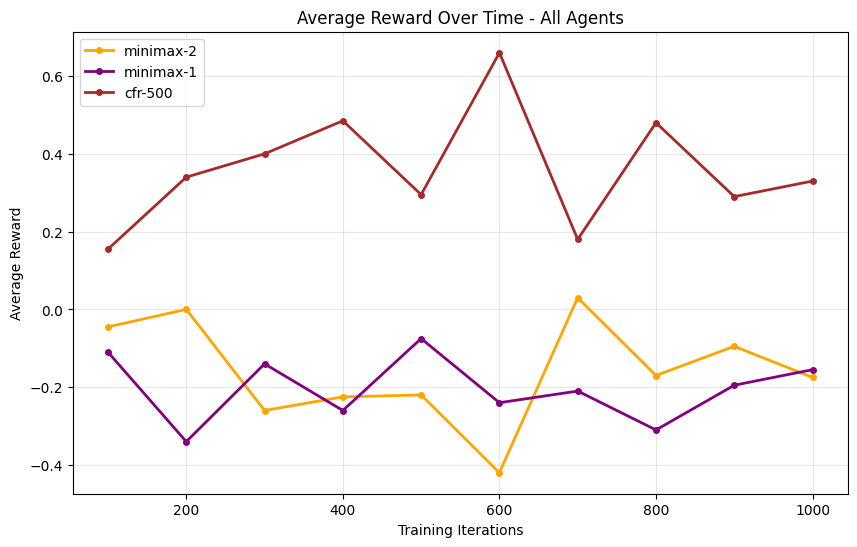

In [28]:
run_experiment(["minimax-2", "minimax-1", 'cfr-500'], n_iters=2000, step=100, graphs=['avg_rewards_by_time'])

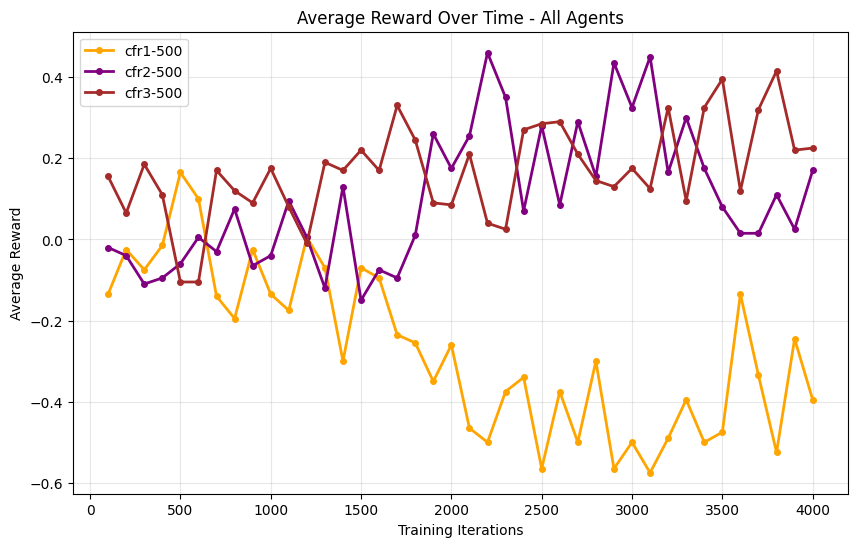

In [21]:
run_experiment(['cfr1-500', 'cfr2-500', 'cfr3-500'], n_iters=8000, step=200, graphs=['avg_rewards_by_time'])

# Evaluación Experimental de Agentes CFR en Kuhn Poker de 2 y 3 Jugadores

## Introducción

El *Kuhn Poker* es un juego secuencial de información imperfecta ampliamente utilizado para investigar algoritmos de aprendizaje y teoría de juegos. En este trabajo analizamos el desempeño de agentes basados en *Counterfactual Regret Minimization* (CFR) frente a otros enfoques clásicos, como agentes *minimax* (búsqueda con profundidad limitada) y agentes aleatorios (*random*), en instancias de 2 y 3 jugadores.

Los agentes CFR son conocidos por converger al equilibrio de Nash en juegos de suma cero de dos jugadores de información imperfecta. Evaluamos diferentes variantes de CFR según el número de pasos de entrenamiento por iteración y su posición relativa en el juego.

---

## Descripción de los Agentes

- **CFR (`cfr-<n>`):** Utiliza el algoritmo *Counterfactual Regret Minimization* con `<n>` actualizaciones por paso de entrenamiento. A mayor número de actualizaciones, se espera una mejor aproximación al equilibrio de Nash.
- **Minimax (`minimax-<p>`):** Realiza búsqueda minimax con profundidad `p`. No modela adecuadamente la incertidumbre ni estrategias mixtas, por lo que se espera que tenga un rendimiento limitado en entornos de información imperfecta.
- **Random:** Juega completamente al azar. Sirve como línea base inferior esperada.

---

## Resultados y Análisis

### 1. Comparación inicial: CFR vs Minimax y Random (2 jugadores)

- `cfr-500` alcanza **recompensas promedio consistentemente positivas**, variando entre ~0.3 y ~0.65 a lo largo del entrenamiento.
- `minimax-1`, `minimax-2` y `random` muestran recompensas promedio **negativas o cercanas a cero**, lo que confirma que no son competitivos contra CFR.
- Esto sugiere que **CFR es claramente superior** a agentes clásicos deterministas en juegos de información imperfecta.

### 2. Rendimiento acumulado y promedio (CFR vs Random)

- En juegos contra `random`, el agente `cfr-500` logra **ganancias acumuladas cercanas a 1000 fichas**, mientras que `random` incurre en pérdidas equivalentes.
- La **recompensa promedio por iteración** también evidencia esta diferencia, con `cfr-500` superando a `random` por un amplio margen (~0.5).
- Esto valida que **CFR no solo converge a estrategias óptimas, sino que también explota eficientemente oponentes subóptimos**.

### 3. CFR vs Minimax (2 jugadores)

- En partidas contra `minimax-1`, `cfr-500` sigue logrando **recompensas positivas y estables**, mientras que `minimax-1` obtiene valores negativos.
- Aunque `minimax-1` es más resistente que `random`, su rendimiento aún es claramente inferior.
- Esto refuerza la noción de que **minimax no es adecuado para juegos como Kuhn Poker**, donde la información oculta es clave.

### 4. CFR en 3 jugadores: Posiciones y convergencia

- En el escenario con `cfr1-500`, `cfr2-500` y `cfr3-500`, se observa que:
  - `cfr2-500` y `cfr3-500` **alcanzan rendimientos promedio positivos**, con menor varianza.
  - `cfr1-500` sufre un **descenso progresivo** en su recompensa, cayendo a valores cercanos a -0.5.
- Este patrón sugiere que:
  - **La posición en el juego afecta significativamente el desempeño** de los agentes CFR.
  - **CFR2 y CFR3 parecen estar alcanzando un equilibrio mutuo**, ya que sus recompensas se estabilizan sin ventaja evidente.
- Este experimento muestra un **indicio de convergencia hacia un equilibrio de Nash parcial**, incluso en el entorno más complejo de tres jugadores.

---

## Conclusiones

1. **CFR supera sistemáticamente a los agentes minimax y random**, tanto en juegos de 2 como de 3 jugadores.
2. **Minimax muestra limitaciones importantes** debido a su naturaleza determinista y suposiciones de información completa.
3. **La posición de juego tiene impacto**, siendo más difícil obtener buenas recompensas como primer jugador (CFR1).
4. En el caso de tres jugadores, se observa que **CFR2 y CFR3 convergen hacia un equilibrio mutuo**, lo cual es consistente con la teoría de juego adaptativo y autojuego en CFR.
